# Bước 1: Import thư viện

In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

# Bước 2: Đọc dữ liệu

In [2]:
# truy cập google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# read csv
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DL/LSTM /MWG.csv")


In [4]:
df.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,05/01/2024,"43,850","43,200","44,100","43,000",9.04M,1.50%
1,04/01/2024,"43,200","43,200","43,800","43,000",8.52M,0.00%
2,03/01/2024,"43,200","42,400","43,450","42,000",6.08M,1.77%
3,02/01/2024,"42,450","43,100","43,300","42,150",7.14M,-0.82%
4,29/12/2023,"42,800","43,200","43,300","42,650",4.18M,-0.58%


# Bước 3: Mô tả dữ liệu

In [5]:
# định dạng thời gian
df["Ngày"] = pd.to_datetime(df.Ngày, format = "%d/%m/%Y")

In [6]:
df.shape

(2371, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371 entries, 0 to 2370
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Ngày        2371 non-null   datetime64[ns]
 1   Lần cuối    2371 non-null   object        
 2   Mở          2371 non-null   object        
 3   Cao         2371 non-null   object        
 4   Thấp        2371 non-null   object        
 5   KL          2371 non-null   object        
 6   % Thay đổi  2371 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 129.8+ KB


# Bước 4: Tiền xử lí dữ liệu

In [8]:
df = df.drop(columns = ["KL","% Thay đổi"], axis =1)

In [9]:
df["Lần cuối"] = df["Lần cuối"].str.replace(",","").astype(int)
df["Mở"] = df["Mở"].str.replace(",","").astype(int)
df["Cao"] = df["Cao"].str.replace(",","").astype(int)
df["Thấp"] = df["Thấp"].str.replace(",","").astype(int)
df.sort_values(by = 'Ngày',inplace= True)

In [10]:
df1 = pd.DataFrame(df,columns = ["Ngày","Lần cuối"])
df1.index = df1.Ngày
df1 = df1.drop(['Ngày'],axis =1 )
df1.head()

,Lần cuối
Ngày,
2014-07-15,4718
2014-07-16,5044
2014-07-17,5396
2014-07-18,5749
2014-07-21,5749


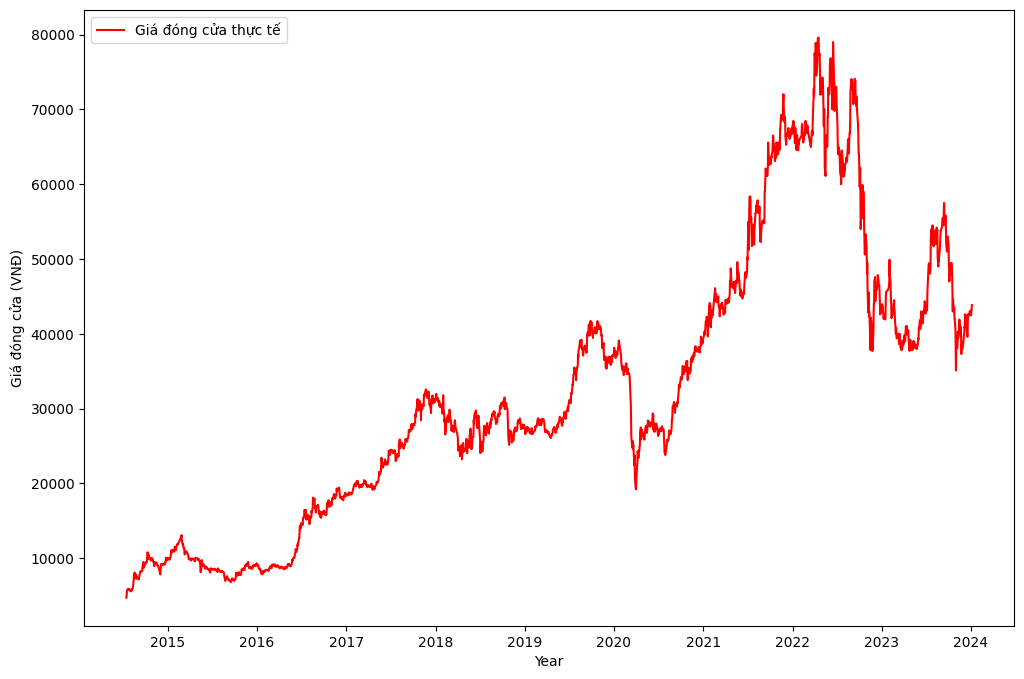

In [31]:
# vẽ biểu đồ
plt.figure(figsize = (12,8))
plt.plot(df1["Lần cuối"], label = "Giá đóng cửa thực tế", c = 'r')
plt.xlabel("Year")
plt.ylabel("Giá đóng cửa (VNĐ)")
plt.legend()

In [32]:
# chia tập dữ liệu
data = df1.values
train_data = data[:1500]
test_data = data[1500:]

In [34]:
len(data)

2371

In [29]:
# chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range = (0,1))
sc_train = sc.fit_transform(train_data)

In [35]:
# đưa ra dự đoán giá hiện tại từ 50 ngày trước đó
x_train, y_train = [], []
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0])
  y_train.append(sc_train[i,0])

In [36]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))


In [37]:
print("x train shape", x_train.shape)
print("y train shape", y_train.shape)

x train shape (1450, 50, 1)
y train shape (1450, 1)


In [38]:
x_train

array([[[0.        ],
        [0.00881033],
        [0.01832333],
        ...,
        [0.12899303],
        [0.12753365],
        [0.12604724]],

       [[0.00881033],
        [0.01832333],
        [0.02786336],
        ...,
        [0.12753365],
        [0.12604724],
        [0.10848062]],

       [[0.01832333],
        [0.02786336],
        [0.02786336],
        ...,
        [0.12604724],
        [0.10848062],
        [0.11726393]],

       ...,

       [[0.57102319],
        [0.58775201],
        [0.60007567],
        ...,
        [0.61242636],
        [0.60272418],
        [0.60183233]],

       [[0.58775201],
        [0.60007567],
        [0.61064267],
        ...,
        [0.60272418],
        [0.60183233],
        [0.60272418]],

       [[0.60007567],
        [0.61064267],
        [0.62120966],
        ...,
        [0.60183233],
        [0.60272418],
        [0.61769634]]])

# Bước 5: Xây dựng mô hình huấn luyện

In [39]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(units = 128, input_shape = (x_train.shape[1],1), return_sequences= True))
model.add(LSTM(units = 64))
model.add(Dropout(0.5)) # loại bỏ 1 số neuron tránh overfitting
model.add(Dense(1)) # output đầu ra 1 chiều
model.compile(loss='mean_absolute_error',optimizer='adam')

In [40]:
  # huấn luyện model
save_model = "/content/drive/MyDrive/Colab Notebooks/DL/LSTM /MWG_LSTM_model.hdf5"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.12061, saving model to /content/drive/MyDrive/Colab Notebooks/DL/LSTM /MWG_LSTM_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 - 7s - loss: 0.1206 - 7s/epoch - 237ms/step
Epoch 2/100

Epoch 2: loss improved from 0.12061 to 0.05901, saving model to /content/drive/MyDrive/Colab Notebooks/DL/LSTM /MWG_LSTM_model.hdf5
29/29 - 6s - loss: 0.0590 - 6s/epoch - 196ms/step
Epoch 3/100

Epoch 3: loss did not improve from 0.05901
29/29 - 3s - loss: 0.0591 - 3s/epoch - 103ms/step
Epoch 4/100

Epoch 4: loss improved from 0.05901 to 0.05560, saving model to /content/drive/MyDrive/Colab Notebooks/DL/LSTM /MWG_LSTM_model.hdf5
29/29 - 3s - loss: 0.0556 - 3s/epoch - 107ms/step
Epoch 5/100

Epoch 5: loss improved from 0.05560 to 0.05093, saving model to /content/drive/MyDrive/Colab Notebooks/DL/LSTM /MWG_LSTM_model.hdf5
29/29 - 3s - loss: 0.0509 - 3s/epoch - 106ms/step
Epoch 6/100

Epoch 6: loss improved from 0.05093 to 0.05093, saving model to /content/drive/MyDrive/Colab Notebooks/DL/LSTM /MWG_LSTM_model.hdf5
29/29 - 6s - loss: 0.0509 - 6s/epoch - 217ms/step
Epoch 7/100

Epoch 7: loss did not improve from 0.05093
29/29 - 

In [41]:
# train data
final_model = load_model("/content/drive/MyDrive/Colab Notebooks/DL/LSTM /MWG_LSTM_model.hdf5")
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train)

46/46 [==============================] - 3s 49ms/step


# Bước 6: Sử dụng mô hình

In [42]:
# xử lí dữ liệu test
input_test_data = df1[len(train_data)-50:].values
#append(test_data,ignore_index = True)
input_test_data = sc.fit_transform(input_test_data)

x_test, y_test = [],[]

for i in range(50,input_test_data.shape[0]):
  x_test.append(input_test_data[i-50:i,0])
  y_test.append(input_test_data[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [43]:
x_test.shape

(871, 50)

In [44]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

In [45]:
print("x test shape", x_test.shape)
print("y test shape", y_test.shape)

x test shape (871, 50, 1)
y test shape (871, 1)


In [47]:
x_test

array([[[0.06309488],
        [0.07010343],
        [0.06017315],
        ...,
        [0.05784294],
        [0.06777322],
        [0.06893832]],

       [[0.07010343],
        [0.06017315],
        [0.06368639],
        ...,
        [0.06777322],
        [0.06893832],
        [0.0642779 ]],

       [[0.06017315],
        [0.06368639],
        [0.05843446],
        ...,
        [0.06893832],
        [0.0642779 ],
        [0.06017315]],

       ...,

       [[0.34427934],
        [0.35324168],
        [0.32635466],
        ...,
        [0.34517557],
        [0.3406944 ],
        [0.33442076]],

       [[0.35324168],
        [0.32635466],
        [0.32635466],
        ...,
        [0.3406944 ],
        [0.33442076],
        [0.34786427]],

       [[0.32635466],
        [0.32635466],
        [0.29946764],
        ...,
        [0.33442076],
        [0.34786427],
        [0.34786427]]])

In [54]:
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict)
y_test = sc.inverse_transform(y_test)


28/28 [==============================] - 1s 38ms/step


In [49]:
# train_data = df1[:1500]
# test_data = df1[1500:]

In [55]:
len(y_test) + len(y_train)

2321

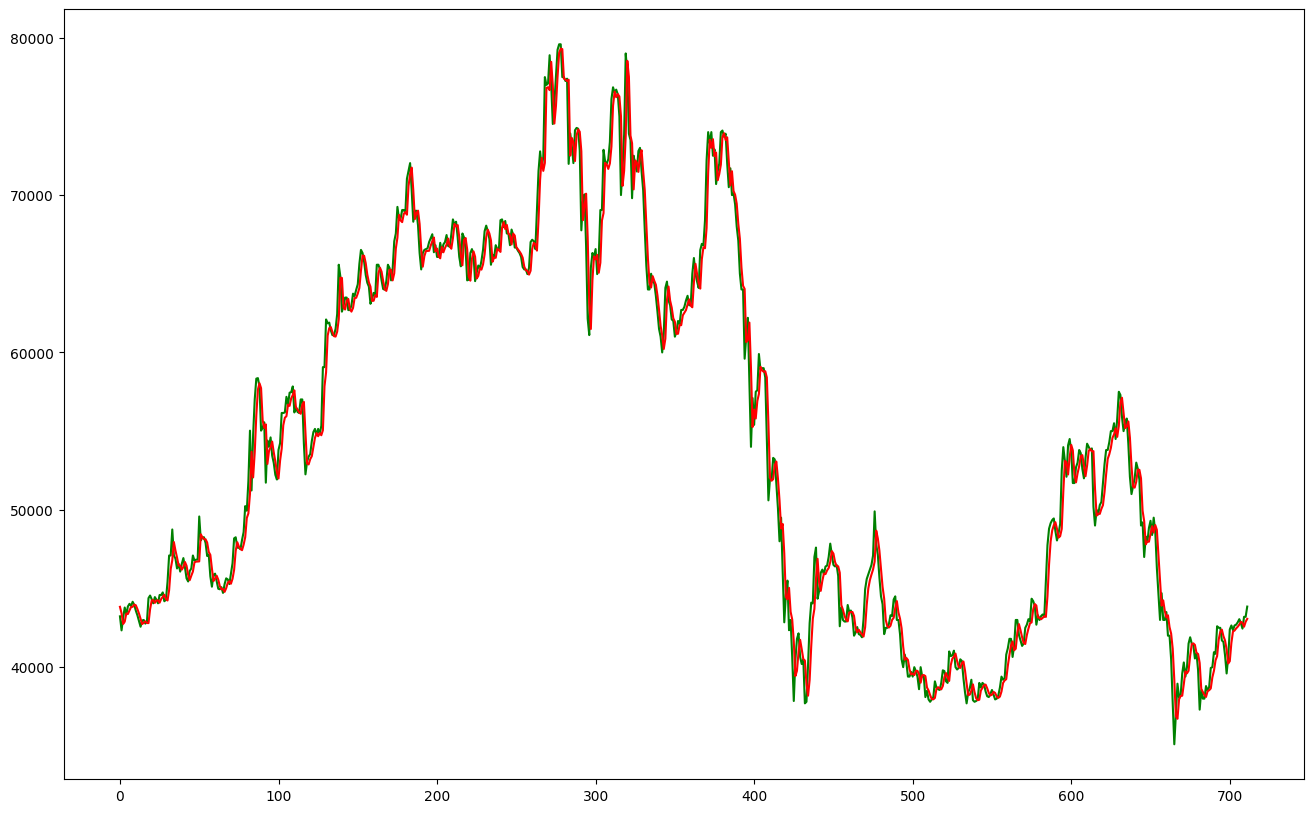

In [ ]:
plt.figure(figsize = (16,10))
plt.plot(y_test,label = "Giá thực tế", c = 'g')

plt.plot(y_test_prediction, label = "Giá dự báo", c = "r")

<ipython-input-64-b42114627356>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1["dự báo train"] = y_train_predict
<ipython-input-64-b42114627356>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1["dự báo test"] = y_test_predict


Text(0, 0.5, 'VND')

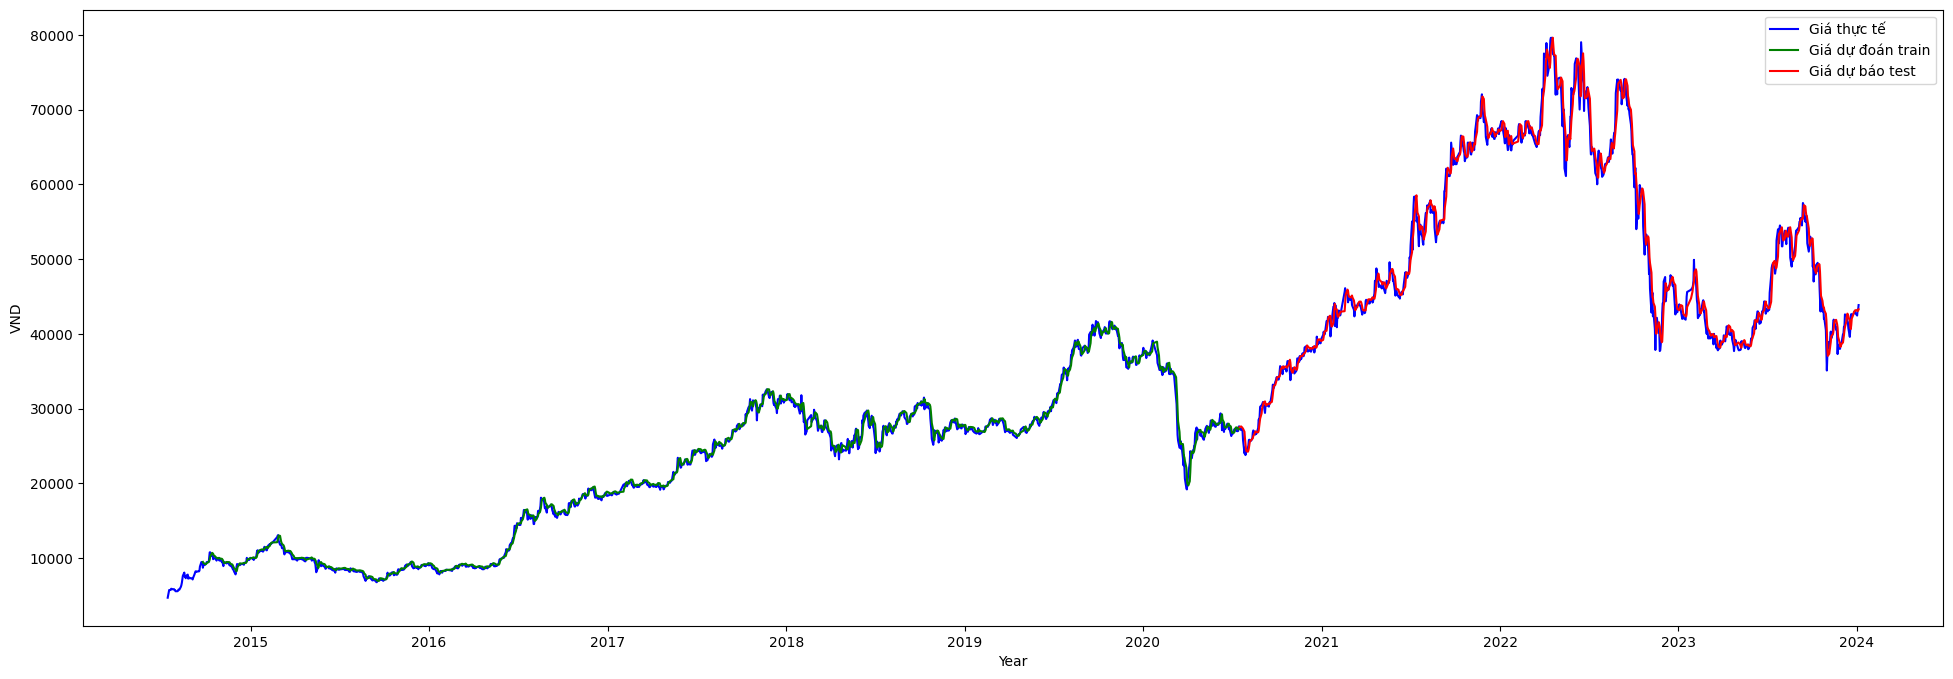

In [64]:
# lập biểu đồ so sánh
train_data1[50:1500]
test_data1[1500:]

plt.figure(figsize = (24,8))
plt.plot(df1,label = 'Giá thực tế', c = 'b') # giá thực tế
train_data1["dự báo train"] = y_train_predict
plt.plot(train_data1["dự báo train"], label = "Giá dự đoán train", c = 'g')
test_data1["dự báo test"] = y_test_predict
plt.plot(test_data1["dự báo test"], label = "Giá dự báo test", c = 'r')
plt.legend()
plt.xlabel("Year")
plt.ylabel("VND")

In [65]:
##r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: -14.890386553931657
Sai số tuyệt đối trung bình trên tập test (VNĐ): 158099737514348.56
Phần trăm sai số tuyệt đối trung bình tập test: 0.9999999996772398
